# <font color='blue'> Ciclo-1 end to end </font>

## 1.0 Data Informations

### 1.1 IMPORTS

In [91]:
import random


import numpy            as np
import pandas           as pd
import matplotlib       as plt
import seaborn          as sns 
import pickle           as pkl


from IPython.display       import Image
from IPython.core.display  import HTML


from category_encoders import              TargetEncoder
from      imblearn     import              combine                  as     c
from      imblearn     import              over_sampling            as     oversamp
from      imblearn     import              under_sampling           as     us
from      scipy        import              stats                    as     ss
from      scikitplot   import              metrics                  as     mt
from      sklearn      import              metrics                  as     m
from      sklearn      import              preprocessing            as     pp
from      keras        import              layers                   as     l
from      keras        import              models                   as     ml
from      sklearn      import              model_selection          as     ms


from      pandas_profiling    import       ProfileReport

### 1.2 Helper functions

In [2]:
def cramer_v( x, y ):
    cm  = pd.crosstab(x,y).values
    n  = cm.sum()
    r,k = cm.shape
    
    chi2      = ss.chi2_contingency(cm)[0]
    chi2corr  = max( 0, chi2 -  (k-1)*(r-1)/(n-1) )
    
    kcorr   =  k  - (k-1)**2/(n-1) 
    rcorr   =  r  - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n) / (min( kcorr-1 , rcorr-1 ) ) )

In [3]:
# general functions
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 
warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning) 
warnings.filterwarnings('ignore')

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 1.3 Loading data

In [5]:
# Users data
data_raw    = pd.read_csv('../dataset/training_users.csv', low_memory=True)

In [6]:
# Sessions data
df_sessions = pd.read_csv('../dataset/sessions.csv',low_memory=True)

## 2.0 Data Description 

### 2.1 Data Dimentions

In [7]:
#=================== Data Users ===================#
df1 = data_raw.copy()

In [8]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [9]:
    #=================== Data Sessions ===================#
dfs_1 = df_sessions.copy()

In [10]:
print( 'Number of rows: {}'.format( dfs_1.shape[0] ) )
print( 'Number of columns: {}'.format( dfs_1.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


### 2.2 Data Type

In [11]:
# ================ Data Users================= # 
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [12]:
# ================ Data Sessions ================= #
dfs_1.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

### 2.3 NA Check

In [13]:
        # ================Data Users================= #
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [14]:
# ================Data Sessions ================= #
dfs_1.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [15]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [16]:
# Fill NA

##==================================      Users       ==================================##
# remove missing value completly
#df1 = df1.dropna()

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )
# age
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# Tratando a Age 
df1 = df1[(df1['age']<120.0) & (df1['age']>15.0)]

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

##==================================      Sessions       ==================================##
# user_id
dfs_1 = dfs_1[~dfs_1['user_id'].isna()]
# action
dfs_1 = dfs_1[~dfs_1['action'].isna()]
# action_type
dfs_1 = dfs_1[~dfs_1['action_type'].isna()]
# action_detail
dfs_1 = dfs_1[~dfs_1['action_detail'].isna()]

# secs_elapsed
dfs_1 = dfs_1[~dfs_1['secs_elapsed'].isna()]
# Tratando a secs_elapsed
dfs_1 = dfs_1[dfs_1['secs_elapsed']>0]

In [17]:
df1.isna().sum() / len( df1 )

id                        0.0000
date_account_created      0.0000
timestamp_first_active    0.0000
date_first_booking        0.0000
gender                    0.0000
age                       0.0000
signup_method             0.0000
signup_flow               0.0000
language                  0.0000
affiliate_channel         0.0000
affiliate_provider        0.0000
first_affiliate_tracked   0.0000
signup_app                0.0000
first_device_type         0.0000
first_browser             0.0000
country_destination       0.0000
dtype: float64

In [18]:
##==================================    Training     ==================================##
dfs_1.isna().sum()/len(dfs_1)

user_id         0.0000
action          0.0000
action_type     0.0000
action_detail   0.0000
device_type     0.0000
secs_elapsed    0.0000
dtype: float64

### 2.4 Change data types

In [19]:
df1.dtypes 

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [20]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

### 2.5 Check balanced data

In [21]:
#df1['country_destination'].value_counts( normalize=True,ascending=True )
df1['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

### 2.6 Descriptive Analysis

In [22]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = dfs_1.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = dfs_1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = dfs_1.select_dtypes( include=['datetime64[ns]'] )

#### 2.6.1 Numerical - Users

In [23]:
# Central tendency- Mean, Median
ct1   =   pd.DataFrame( num_attributes.apply( np.mean  ) ).T
ct2   =   pd.DataFrame( num_attributes.apply( np.median  ) ).T

# Dispersion- Std, min, max, range, skew, kurtosis.
d1    =   pd.DataFrame( num_attributes.apply( np.std ) ).T
d2    =   pd.DataFrame( num_attributes.apply( lambda x: x.min( ) ) ).T
d3    =   pd.DataFrame( num_attributes.apply( lambda x: x.max( ) ) ).T
d4    =   pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5    =   pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T
d6    =   pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ) ).T

# Concatenar
users_num = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
users_num.columns = ['Atributos','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
users_num

,Atributos,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,age,16.0000,115.0000,99.0000,42.1174,49.0000,12.1565,1.0020,4.6261
1,signup_flow,0.0000,25.0000,25.0000,3.1569,0.0000,7.5507,2.2838,3.5516


#### 2.6.2 Numerical - Sessions

In [24]:
# Central tendency- Mean, Median
cts1    =     pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
cts2    =     pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersion- Std, min, max, range, skew, kurtosis.
ds1     =   pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
ds2     =   pd.DataFrame( num_attributes_sessions.apply(lambda x: x.min() ) ).T
ds3     =   pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() ) ).T
ds4     =   pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
ds5     =   pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
ds6     =   pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
sessions_num = pd.concat( [ds2,ds3,ds4,cts1,cts2,ds1,ds5,ds6]).T.reset_index()
sessions_num.columns = ['Atributos','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
sessions_num

,Atributos,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,secs_elapsed,1.0000,"1,799,977.0000","1,799,976.0000","20,159.4743","1,409.0000","89,265.8545",11.0848,153.3537


#### 2.6.3 Categorical-Users

In [25]:
cat_attributes.drop('id',axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,206593,206593,206593,206593,206593,206593,206593,206593,206593,206593
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91706,147635,199636,133678,133438,108838,177591,89255,63620,119810


#### 2.6.4 Categorical-Sessions

In [26]:
cat_attributes_sessions.drop('user_id',axis=1).describe()

,action,action_type,action_detail,device_type
count,9123594,9123594,9123594,9123594
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2161240,3518629,1754981,2989495


### 2.6.5. Correlation Matrix - Sessions

In [27]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id',axis=1).columns.tolist()

# Lista de attributos para o Cramer's V correlation
corr_dict = {}
for i in range (len( cat_attributes_list ) ):
    corr_list = []
    for j in range(len( cat_attributes_list ) ):
        ref  =  cat_attributes_list[i]
        feat =  cat_attributes_list[j]
        
        # Correlation
        corr = cramer_v( cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # Append da lista 
        corr_list.append( corr )
    
    # Append a correlation list for each ref attributes
    corr_dict[ ref ] = corr_list   
    

<AxesSubplot:>

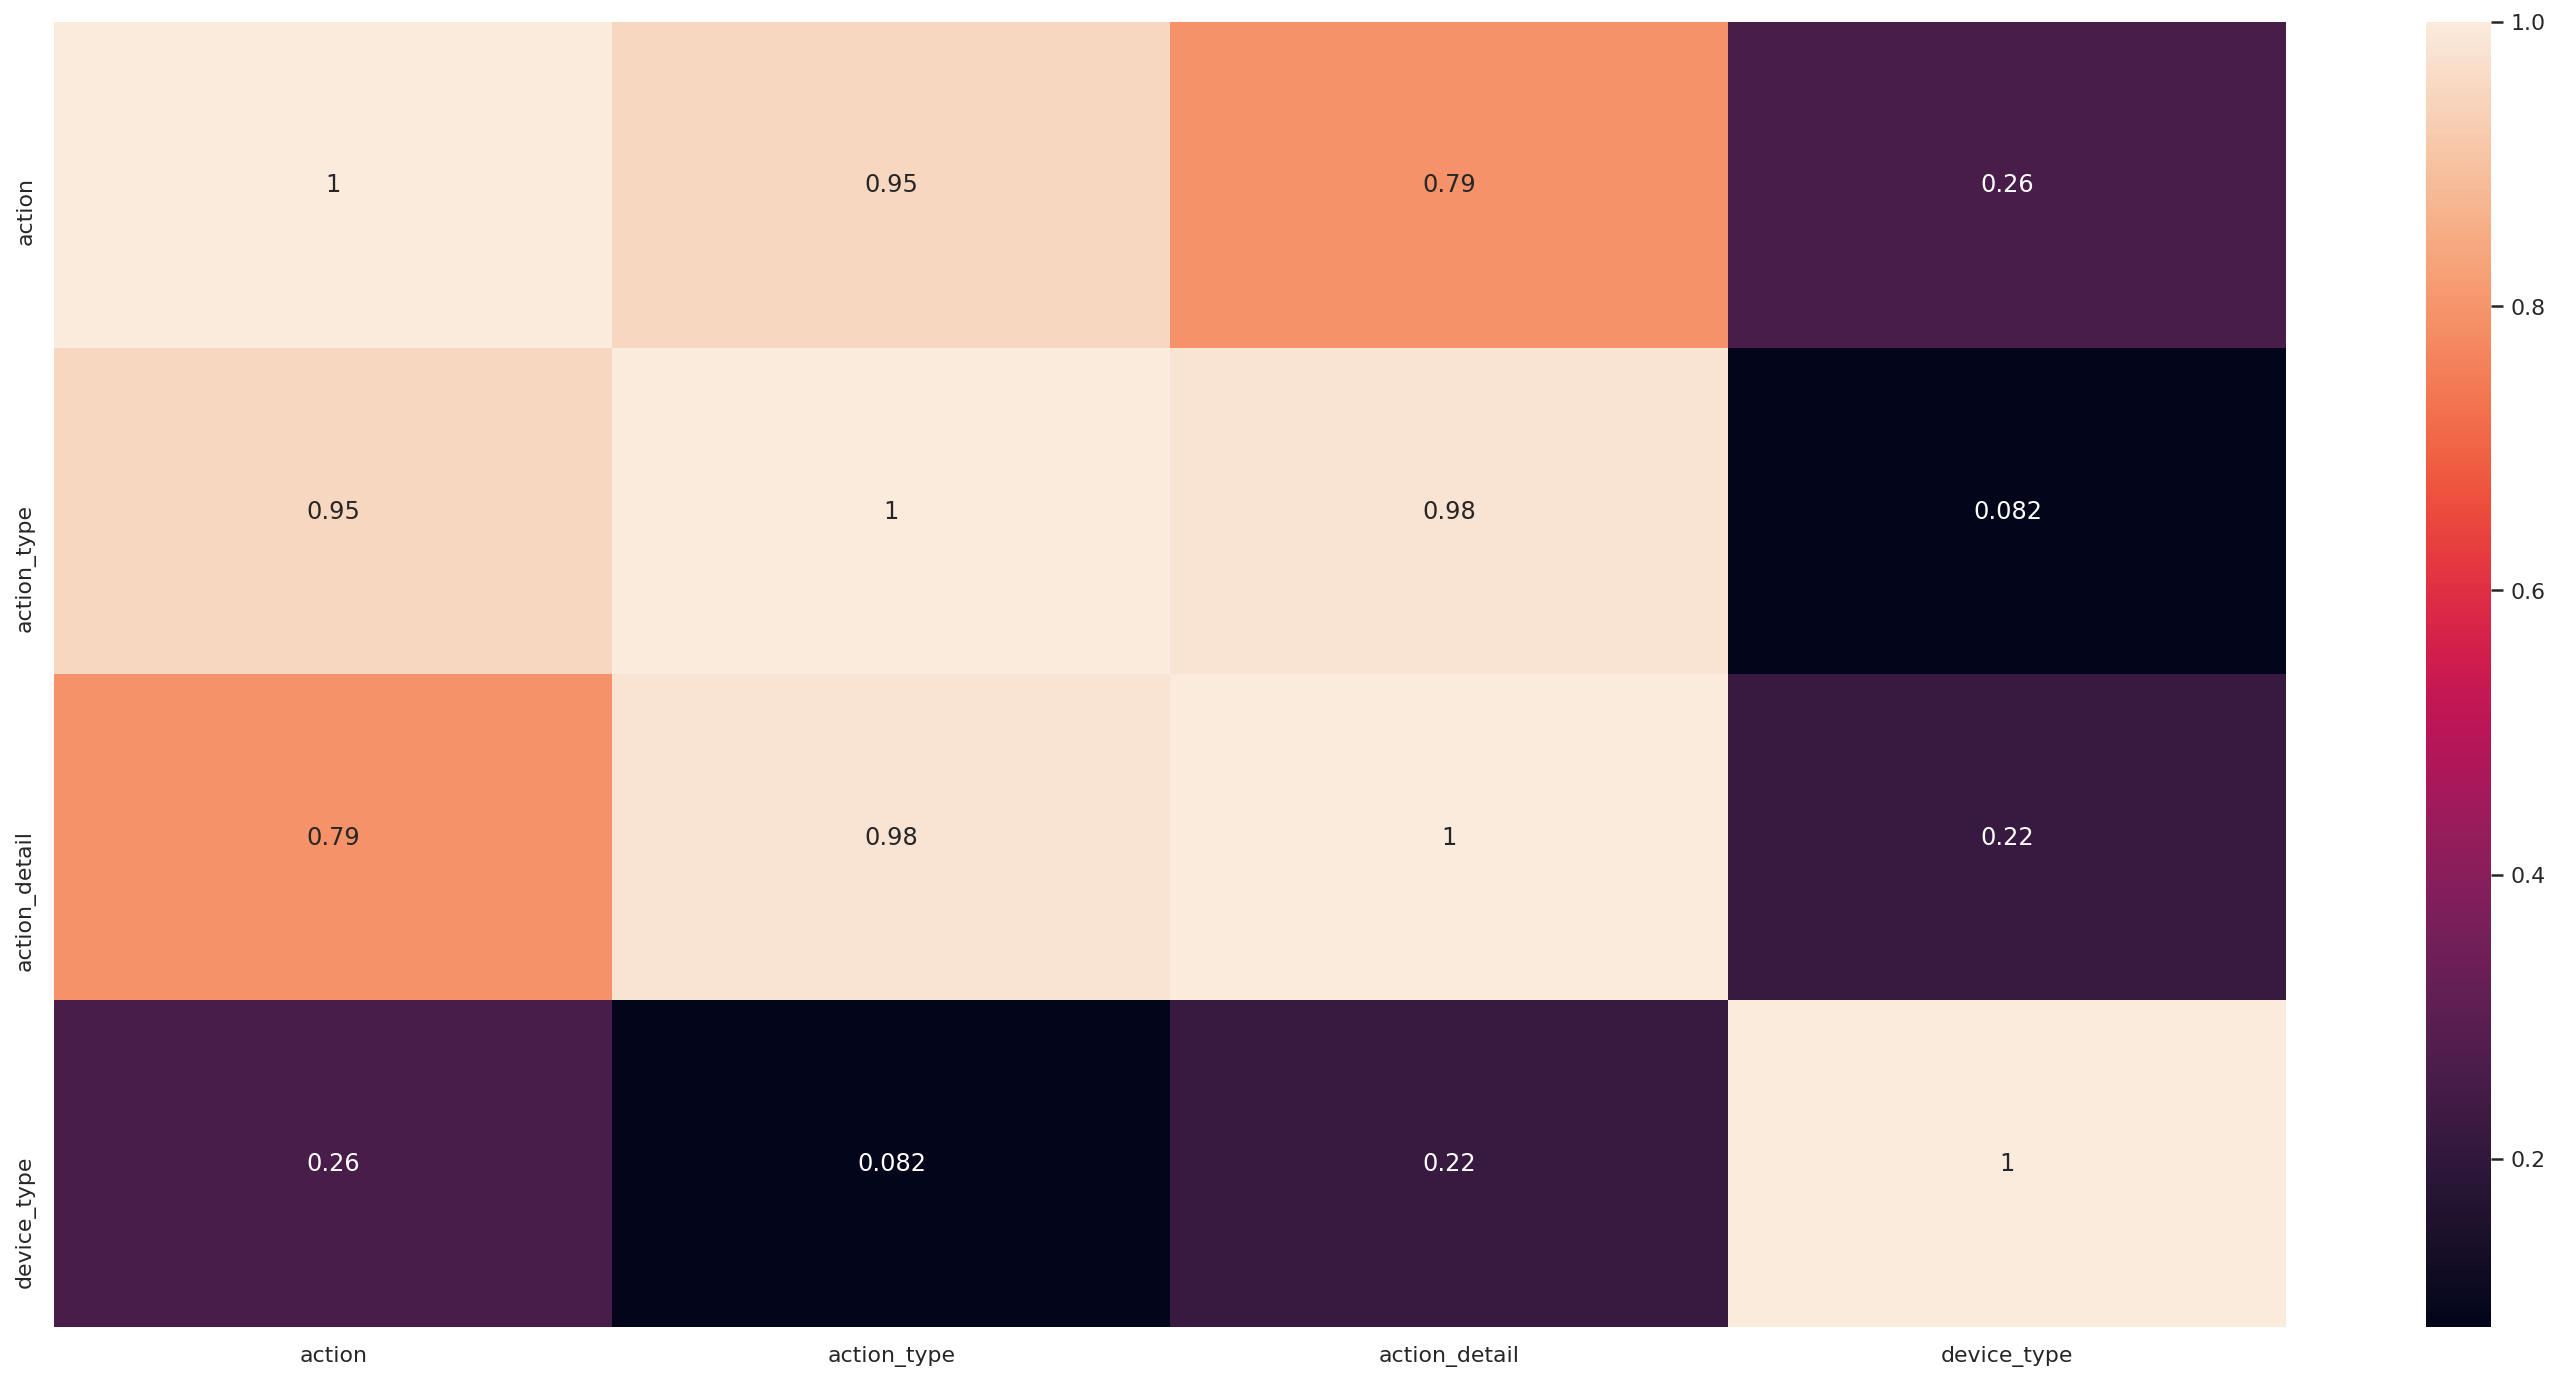

In [28]:
d = pd.DataFrame( corr_dict)
d = d.set_index( d.columns )
sns.heatmap( d ,annot=True )

## 3.0 Feature Engineering 

In [29]:
df2 = df1.copy()
df2.shape

(206593, 16)

In [30]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 3.1 Create New Features

In [31]:
# Days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)
# Days from first active up to account created 
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)
# Days from account created up to first booking 
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created'] ).apply(lambda x: x.days)

#======================== First active ========================#
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['dayofweek_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['weekodyear_first_active'] = df2['first_active'].dt.weekofyear

#======================== First booking ========================#

# year first booking 
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first active
df2['dayofweek_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['weekofyear_first_booking'] = df2['date_first_booking'].dt.weekofyear

#======================== First Account Created ========================#

# year First Account Created
df2['year_first_created_account'] = df2['date_account_created'].dt.year

# month First Account Created
df2['month_first_created_account'] = df2['date_account_created'].dt.month

# day First Account Created
df2['day_first_created_account'] = df2['date_account_created'].dt.day

# day of week First Account Created
df2['dayofweek_first_created_account'] = df2['date_account_created'].dt.dayofweek

# week of year First Account Created
df2['weekofyear_first_created_account'] = df2['date_account_created'].dt.weekofyear



In [32]:
df2.shape

(206593, 35)

In [33]:
df2[['id', 'date_account_created', 'day_first_created_account', 'day_first_booking']].sample(10)

,id,date_account_created,day_first_created_account,day_first_booking
63602,97bexkt2pi,2013-03-05,5,7
16427,pzn6erkmlt,2012-02-05,5,15
127061,eml1vblp8y,2013-11-23,23,15
209883,y35iele5nd,2014-06-24,24,8
40581,m1hg2cphrm,2012-09-12,12,15
65654,i7wq1hla6z,2013-03-16,16,15
199083,efqvyufu4z,2014-06-03,3,3
108399,ckzcainw2n,2013-09-17,17,15
120610,xj9ccf87uh,2013-10-30,30,2
80132,y13joftvp2,2013-05-28,28,30


## 4.0 Data Filtering

In [34]:
a = [2100, 3500, 4000, 8000, 10000, 16000]
b = [19, 28, 29, 30, 31, 32]

( 19 - np.mean( b ) ) / np.std( b )

-2.132808519406074

In [35]:
np.mean( b )

28.166666666666668

In [36]:
np.std( b ) 

4.297932319409209

In [37]:
df3 = df2.copy()
df3.shape

(206593, 35)

### 4.1 Filtering rows

In [38]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

### 4.2 Columns selection

In [39]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

## 5.0 Balanced dataset

In [40]:
df4 = df3.drop( cols, axis=1 )
df4.shape

(206593, 31)

In [41]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(206593, 150)

### 5.1 Random Undersampling

In [42]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )


In [43]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [44]:
y_under.value_counts()

US       60800
NDF      10000
other     9935
FR        4881
IT        2776
GB        2285
ES        2203
CA        1385
DE        1033
NL         746
AU         526
PT         213
Name: country_destination, dtype: int64

### 5.2 Random Oversampling

In [45]:
# Ratio Balanced
ratio_balanced = {'IT':40000,'GB':40000,'ES':40000,'CA':40000,'DE':40000,'NL':40000,'AU':40000,'PT':40000,'other':40000,'FR':40000}

# Definir o sampler
oversamplig = oversamp.RandomOverSampler(sampling_strategy=ratio_balanced,random_state=32)

# Aplicar o sampler
X_over,y_over = oversamplig.fit_resample(df4,df4['country_destination'] )


In [46]:
df4['country_destination'].value_counts() 

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [47]:
y_over.value_counts() 

NDF      119810
US        60800
IT        40000
AU        40000
DE        40000
ES        40000
PT        40000
GB        40000
CA        40000
other     40000
NL        40000
FR        40000
Name: country_destination, dtype: int64

### 5.3 SMOTE + TomekLink

In [48]:
#df4['country_destination'].value_counts().to_dict()
ratio_balanced = {'other': int(3.019627579265224*9935),
                   'FR': int(6.146281499692686*4881),
                   'IT': int(10.446685878962535*2776),
                   'GB': int(12.691466083150985*2285),
                   'ES': int(12.70994098955969*2203),
                   'CA': int(20.216606498194945*1385),
                   'DE': int(26.137463697967085*1033),
                   'NL': int(33.51206434316354*746),
                   'AU': int(45.627376425855516*526),
                   'PT': int(103.28638497652582*213)}

In [49]:
# Ratio Balanced
ratio_balanced

{'other': 30000,
 'FR': 30000,
 'IT': 28999,
 'GB': 29000,
 'ES': 28000,
 'CA': 28000,
 'DE': 27000,
 'NL': 25000,
 'AU': 24000,
 'PT': 22000}

In [50]:
# Definir o sampler
#smt           = c.SMOTETomek(sampling_strategy=ratio_balanced,random_state=32,n_jobs=-1)


# Aplicar o sampler
#x_smt,y_smt   = smt.fit_resample(df42,df4['country_destination'])
with open("../y_smt_pickle","rb") as f:
    y_smt = pkl.load(f)


with open("../large_files/x_smt_pickle.pkl","rb") as f:
    X_smt = pkl.load(f)


In [51]:
y_smt.value_counts()

NDF      119810
US        59266
FR        29601
other     29070
GB        28818
IT        28790
CA        27914
ES        27840
DE        26934
NL        24974
AU        23985
PT        21999
Name: country_destination, dtype: int64

In [52]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

## 6.0. Exploratory Data Analysis ( EDA )

### 6.1. Hypothesys Validation ( Unbalanced Dataset )

In [53]:
df51 = df4.copy()

**H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.

**Verdadeiro**. Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

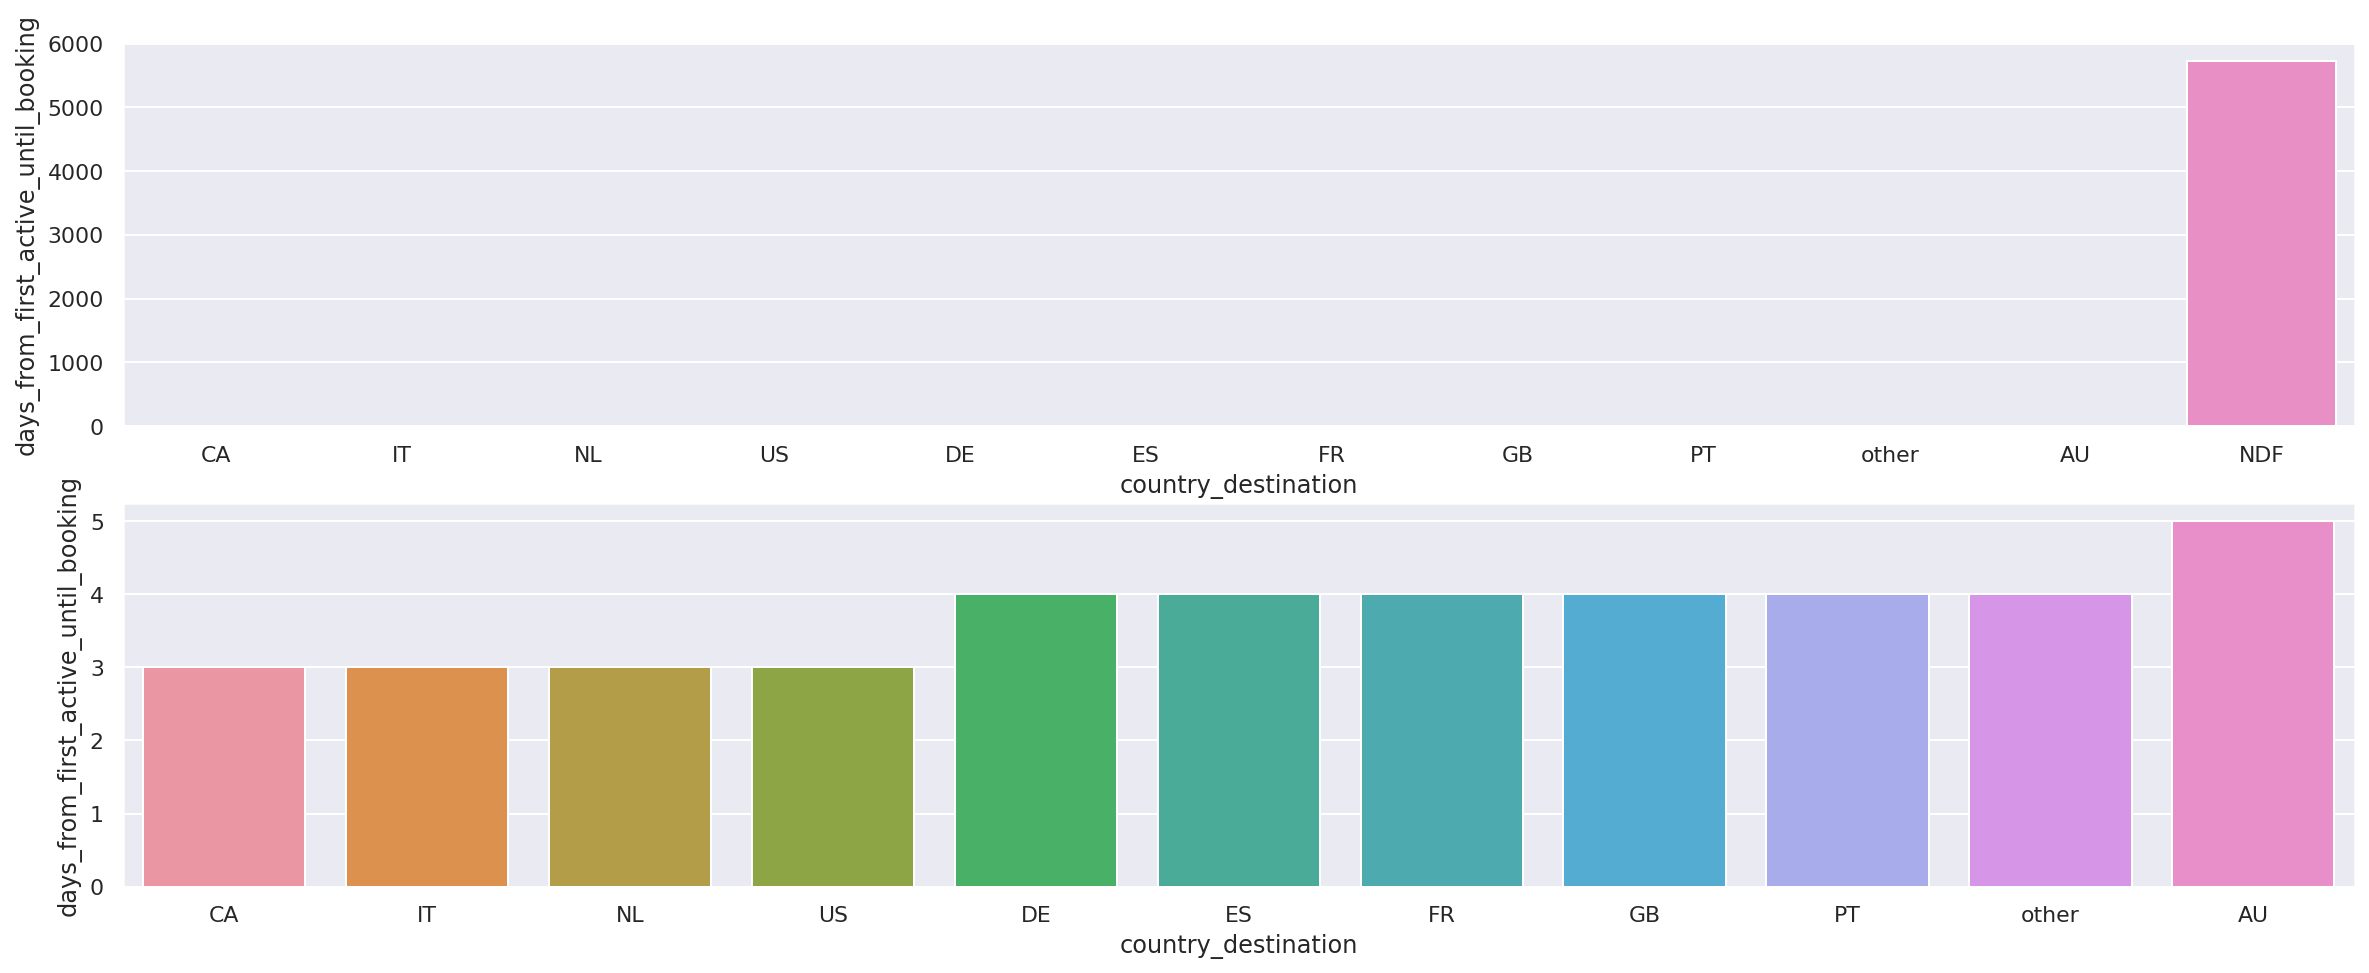

In [54]:
plt.figure( figsize=(20, 12))
plt.subplot( 3, 1, 1 )
aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values( 'days_from_first_active_until_booking' ) )

# remove outlier
plt.subplot( 3, 1, 2 )
aux02 = df51[df51['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values( 'days_from_first_active_until_booking' ) )

**H02.** Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.

**Verdadeira.** Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

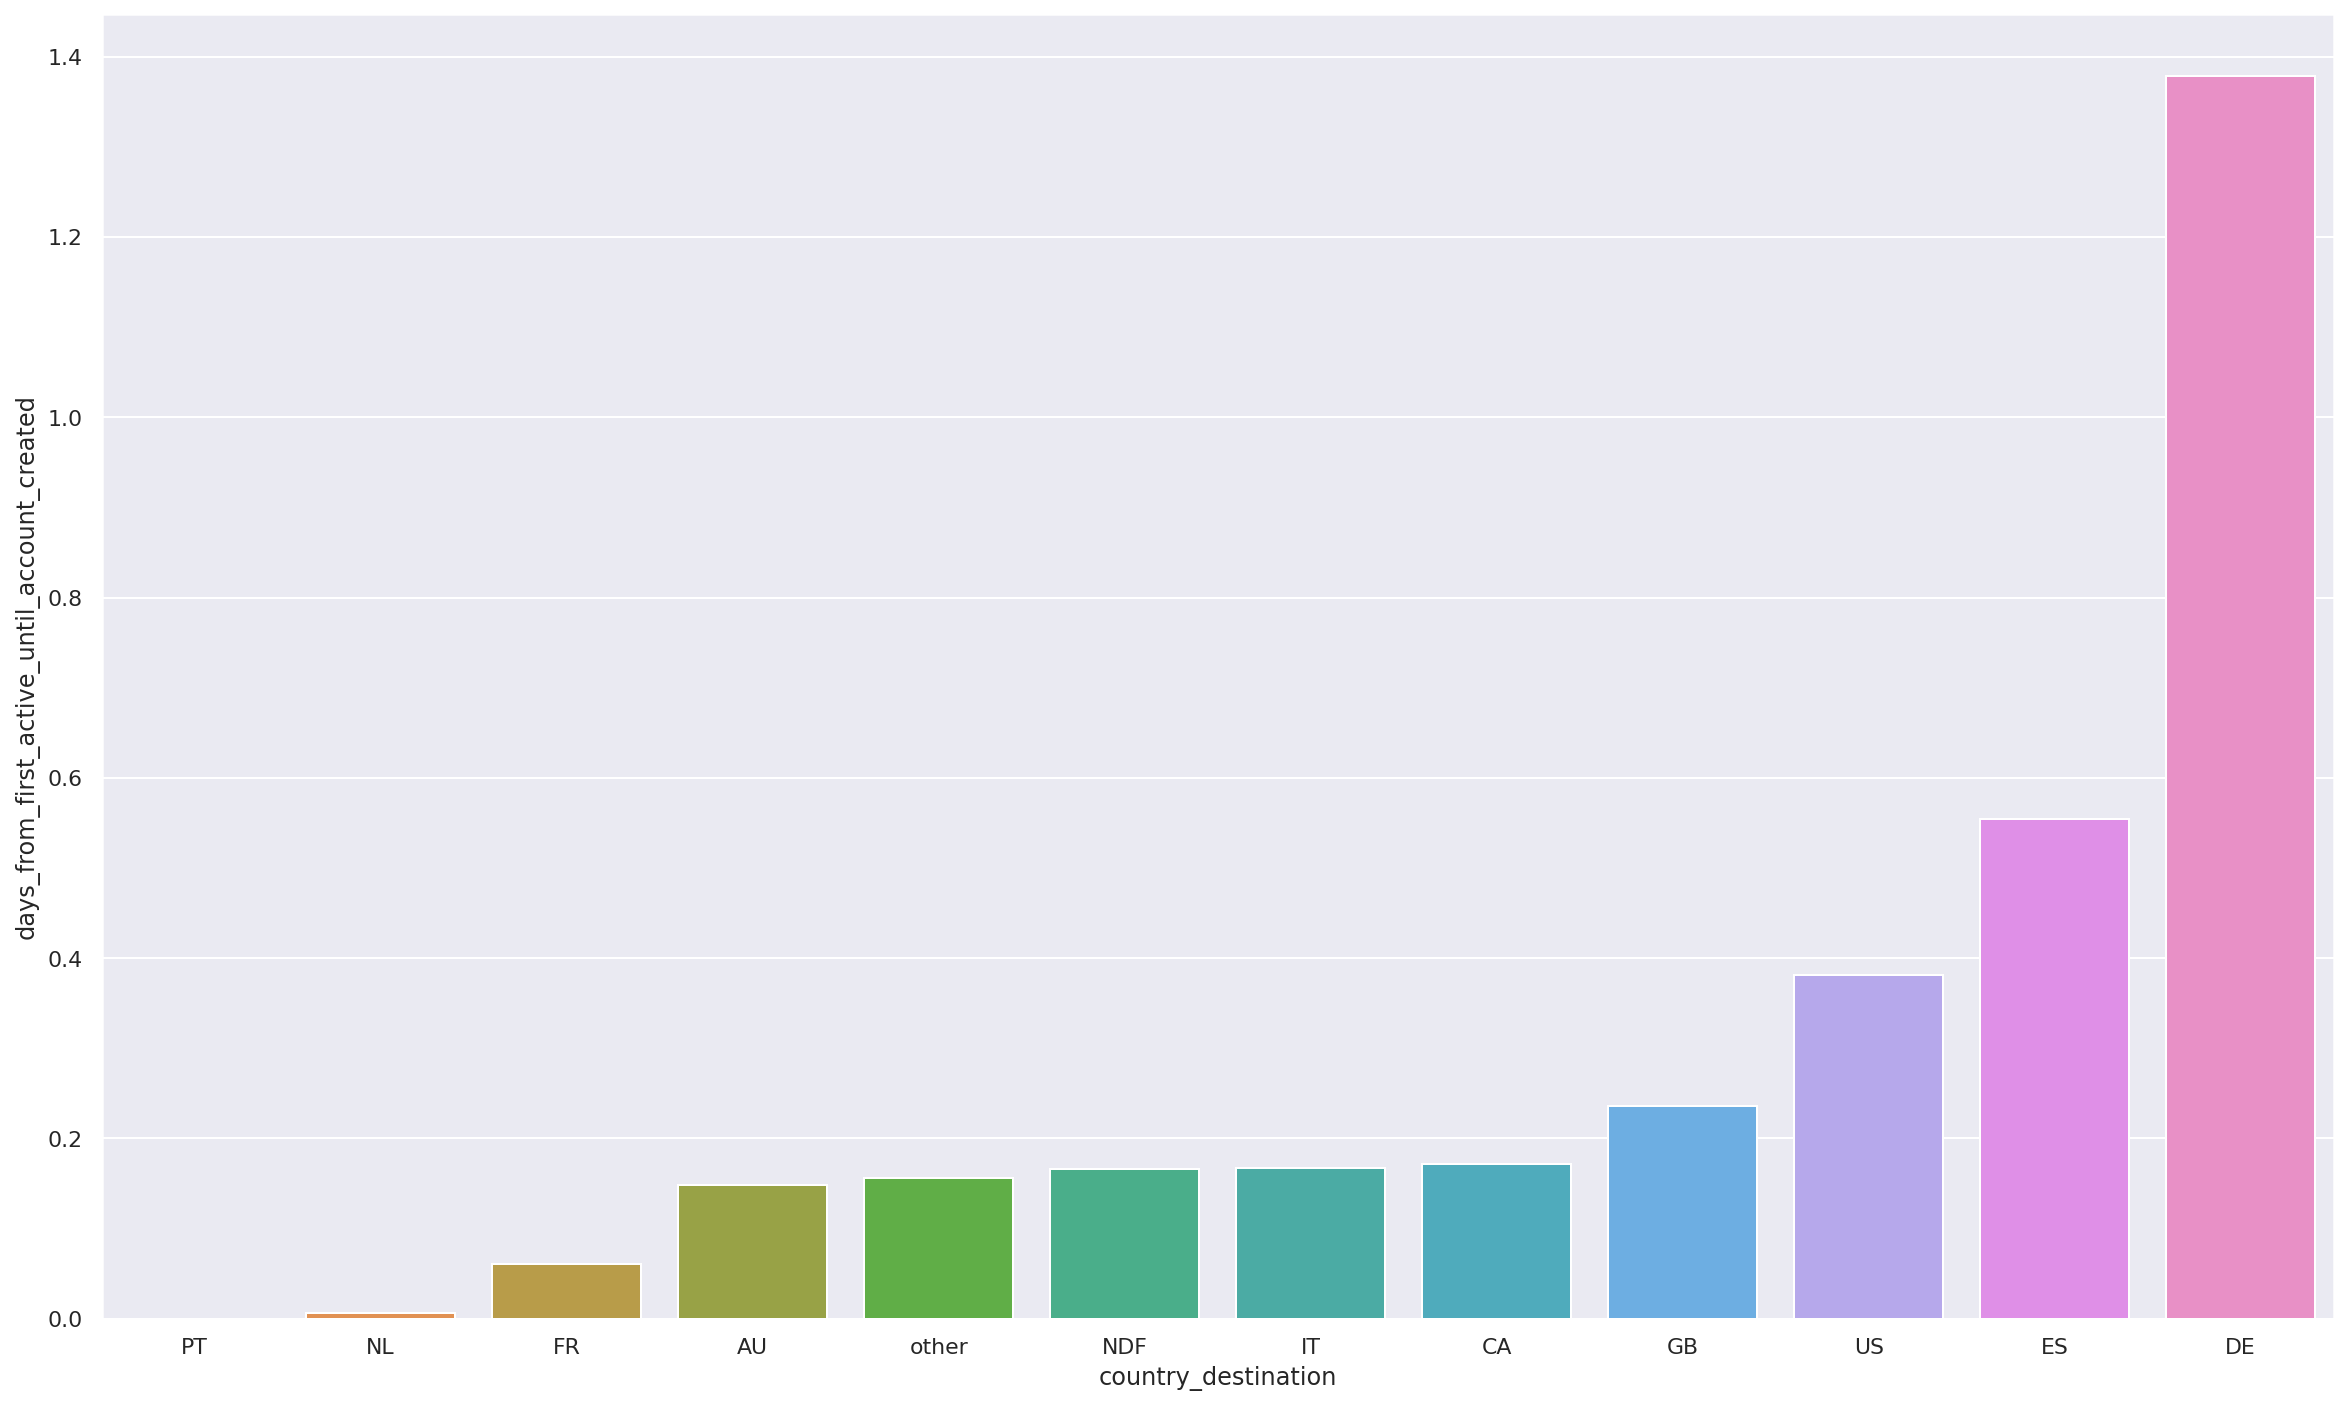

In [55]:
plt.figure( figsize=(20, 12))
aux01 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby( 'country_destination' ).mean().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values( 'days_from_first_active_until_account_created' ) )

 **H03.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**False.** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

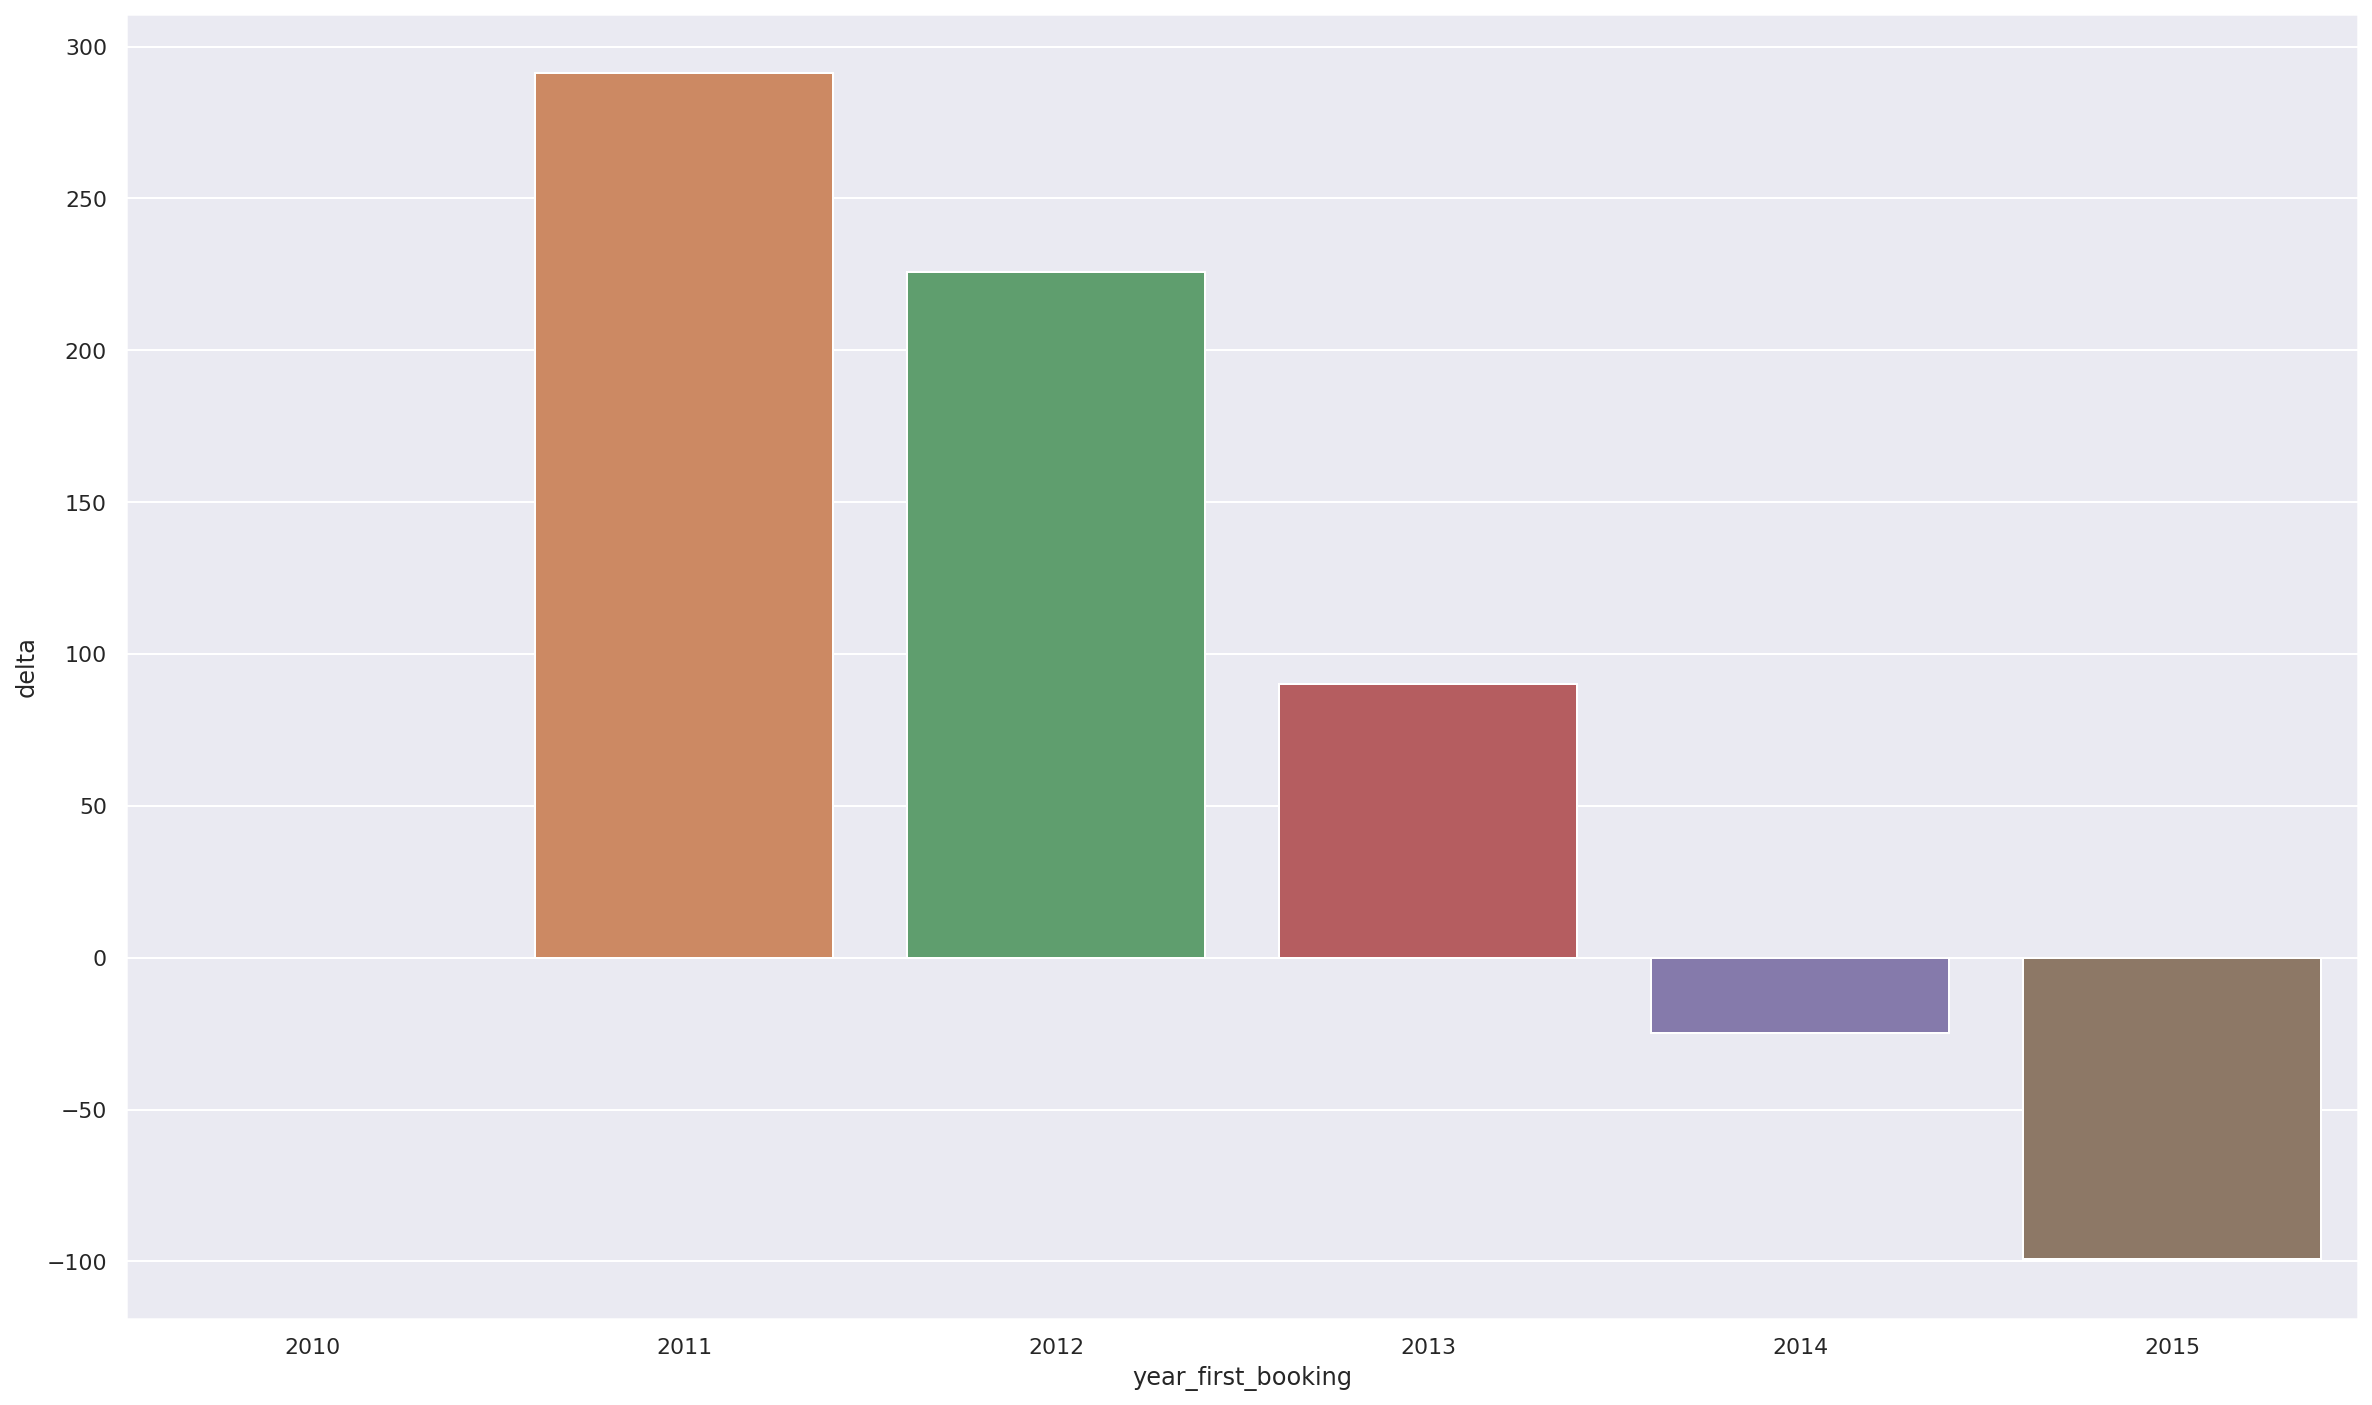

In [56]:
aux01 = df51[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby( ['year_first_booking', 'month_first_booking', 'country_destination'] ). \
                size().reset_index().rename( columns={0:'count'})

# select only summer
aux01 = aux01[( aux01['month_first_booking'].isin( [6, 7, 8, 9] ) ) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna( 0 )

plt.figure( figsize=(20,12))
sns.barplot( x='year_first_booking', y='delta', data=aux02)

### 6.2. Variables Impact ( Balanced Dataset )

In [57]:
df52 = df4.copy() 

### 6.2.1. Univariate Analysis

In [58]:
profile = ProfileReport( df52, title='Airbnb Booking' )
#profile.to_notebook_iframe()
profile.to_file( output_file='airbnb_booking_statistics_after_cleaning.html' )

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [59]:
# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

### 6.2.2. Bivariate Analysis

### 6.2.3. Multivariate Analysis

In [60]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'dayofweek_first_active', 'weekodyear_first_active', 'month_first_booking', 'month_first_created_account',
        'year_first_booking', 'weekofyear_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

## 7.0 Data Preparation 

In [61]:
df6 = df46.drop( cols, axis=1 )
df6.shape

(449001, 16)

In [62]:
df6.dtypes

age                                               int64
signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
dayofweek_first_booking                           int64
year_first_created_account                        int64
day_first_created_account                         int64
dayofweek_first_created_account                   int64
weekofyear_first_created_account                  int64
gender                                           object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

### 7.1 Rescaling

In [63]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [64]:
# age - Standardization
df6['age'] = ss.fit_transform( df6[['age']].values )

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform( df6[['signup_flow']].values )

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform( df6[['days_from_first_active_until_account_created']].values )

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform( df6[['days_from_account_created_until_first_booking']].values )

# year_account_created - MinMax Scaler
df6['year_first_created_account'] = mms.fit_transform( df6[['year_first_created_account']].values )

### 7.2. Encoding

In [65]:
te = TargetEncoder()

In [66]:
# gender - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['gender'], columns=['gender'] )

# signup_method - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_method'], columns=['signup_method'] )

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( c ) )

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( c ) )

### 7.3. Transformation

In [67]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['weekofyear_first_created_account'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_of_year_account_created_cos'] = df6['weekofyear_first_created_account'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['dayofweek_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_first_booking_cos'] = df6['dayofweek_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# day_account_created
df6['day_account_created_sin'] = df6['day_first_created_account'].apply( lambda x: np.sin( x * (2*np.pi/31 ) ) )
df6['day_account_created_cos'] = df6['day_first_created_account'].apply( lambda x: np.cos( x * (2*np.pi/31 ) ) )

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['dayofweek_first_created_account'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_account_created_cos'] = df6['dayofweek_first_created_account'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

## 8.0 Feature Selection

In [68]:
df7 = df6.copy()

In [92]:
X = df6.drop( 'country_destination', axis=1 )
y = df6['country_destination'].copy()

In [93]:
# split dataset into training and test
X_train, X_test,y_train, y_test =  ms.train_test_split( X , y, test_size=0.2, random_state=32 )

## 9.0 Machine Learning Model

### 9.1 Baseline Model

In [95]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num ) 

Accuracy: 0.20331622142292402
Balanced Accuracy:0.08315835621000821
Kappa Score: 0.0005297798168657497
              precision    recall  f1-score   support

          AU       0.03      0.00      0.00      4757
          CA       0.07      0.01      0.01      5539
          DE       0.05      0.00      0.01      5407
          ES       0.07      0.01      0.02      5517
          FR       0.06      0.02      0.03      5802
          GB       0.06      0.01      0.02      5710
          IT       0.06      0.01      0.02      5769
         NDF       0.27      0.58      0.37     24103
          NL       0.05      0.00      0.01      5023
          PT       0.04      0.00      0.00      4443
          US       0.13      0.30      0.18     11933
       other       0.06      0.05      0.05      5798

    accuracy                           0.20     89801
   macro avg       0.08      0.08      0.06     89801
weighted avg       0.12      0.20      0.13     89801



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

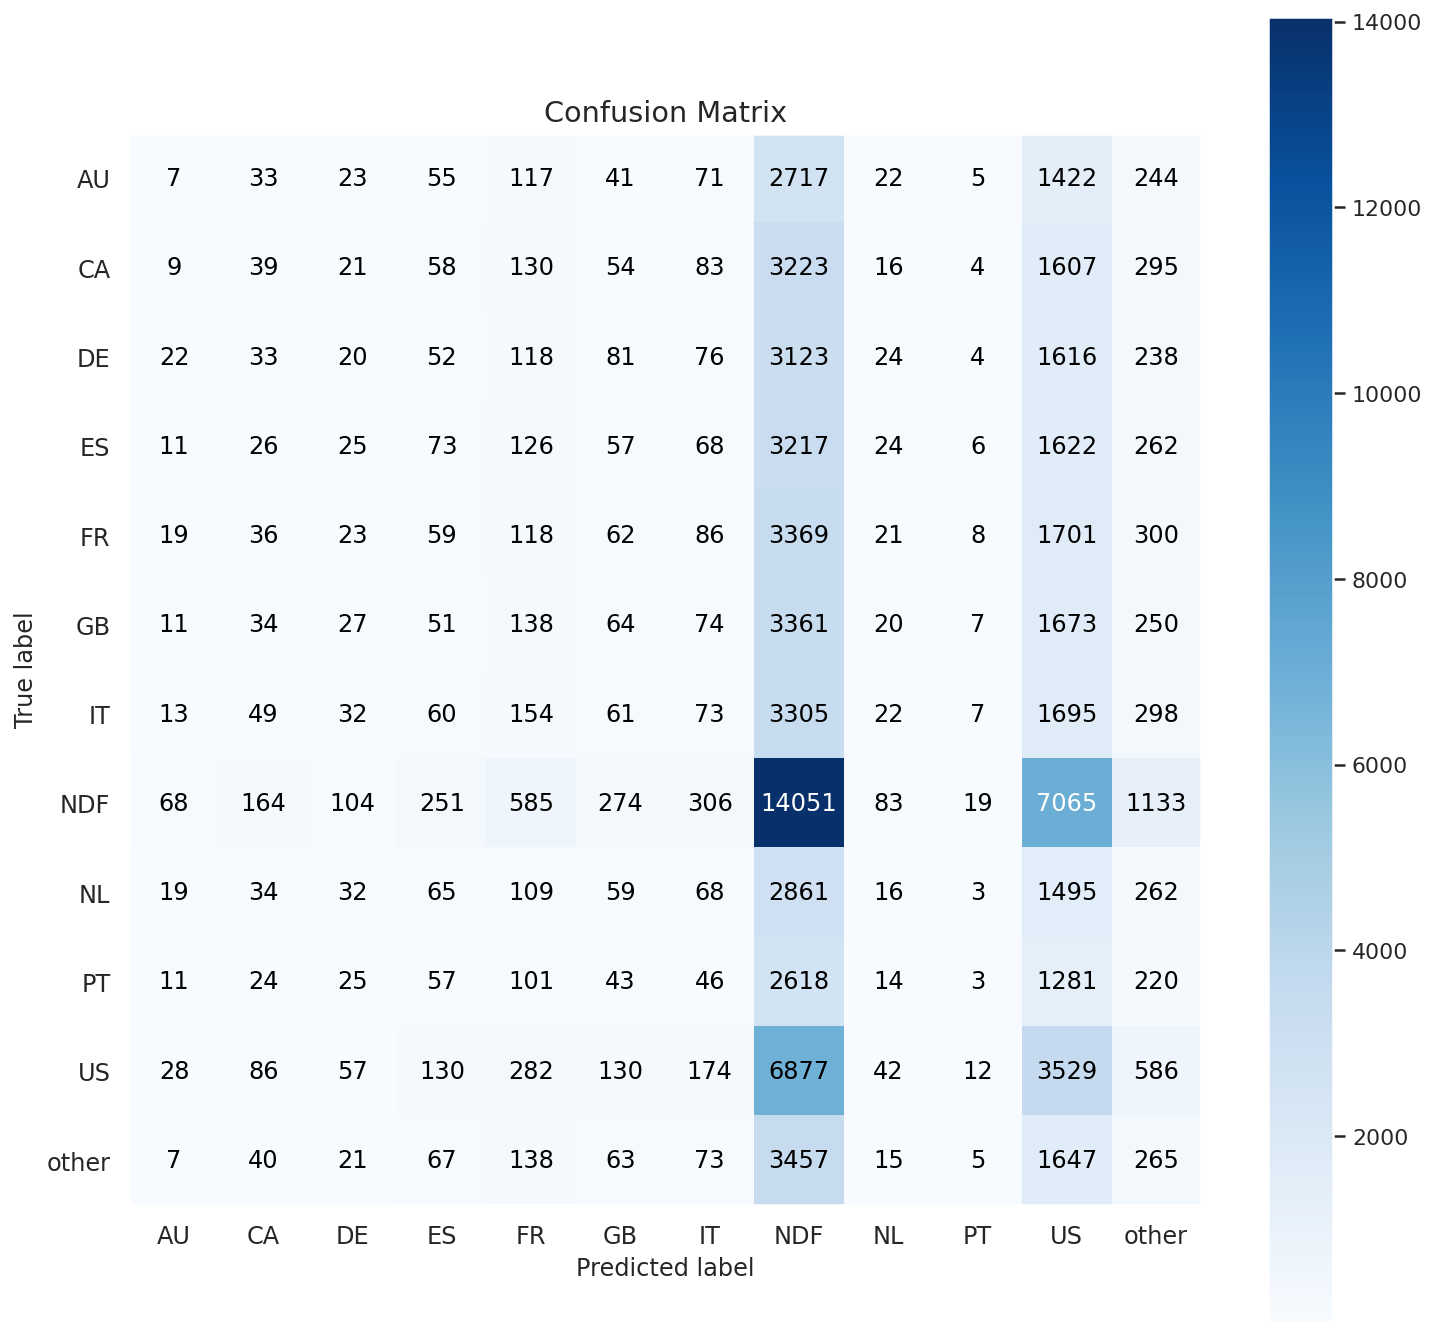

In [97]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

### 9.1 Neural Network - MLP

In [98]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [100]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 64, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=50 )

Epoch 1/50
11225/11225 [==============================] - 9s 650us/step - loss: 1.9005 - accuracy: 0.3721
Epoch 2/50
11225/11225 [==============================] - 7s 627us/step - loss: 1.6872 - accuracy: 0.4061
Epoch 3/50
11225/11225 [==============================] - 7s 627us/step - loss: 1.6601 - accuracy: 0.4162
Epoch 4/50
11225/11225 [==============================] - 7s 591us/step - loss: 1.6429 - accuracy: 0.4228
Epoch 5/50
11225/11225 [==============================] - 7s 611us/step - loss: 1.6301 - accuracy: 0.4268
Epoch 6/50
11225/11225 [==============================] - 8s 685us/step - loss: 1.6164 - accuracy: 0.4326
Epoch 7/50
11225/11225 [==============================] - 7s 607us/step - loss: 1.6060 - accuracy: 0.4348
Epoch 8/50
11225/11225 [==============================] - 7s 636us/step - loss: 1.6008 - accuracy: 0.4383
Epoch 9/50
11225/11225 [==============================] - 7s 628us/step - loss: 1.6009 - accuracy: 0.4402
Epoch 10/50
11225/11225 [=====================

### 9.1.2 NN Performance

In [101]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.4511753766661841
Balanced Accuracy:0.2900254741946796
Kappa Score: 0.36469413178492593
              precision    recall  f1-score   support

          AU       0.23      0.40      0.29      4757
          CA       0.15      0.10      0.12      5539
          DE       0.20      0.17      0.18      5407
          ES       0.18      0.06      0.09      5517
          FR       0.16      0.08      0.11      5802
          GB       0.14      0.04      0.06      5710
          IT       0.18      0.04      0.06      5769
         NDF       1.00      1.00      1.00     24103
          NL       0.21      0.19      0.20      5023
          PT       0.35      0.79      0.48      4443
          US       0.27      0.62      0.38     11933
       other       0.18      0.00      0.01      5798

    accuracy                           0.45     89801
   macro avg       0.27      0.29      0.25     89801
weighted avg       0.42      0.45      0.41     89801



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

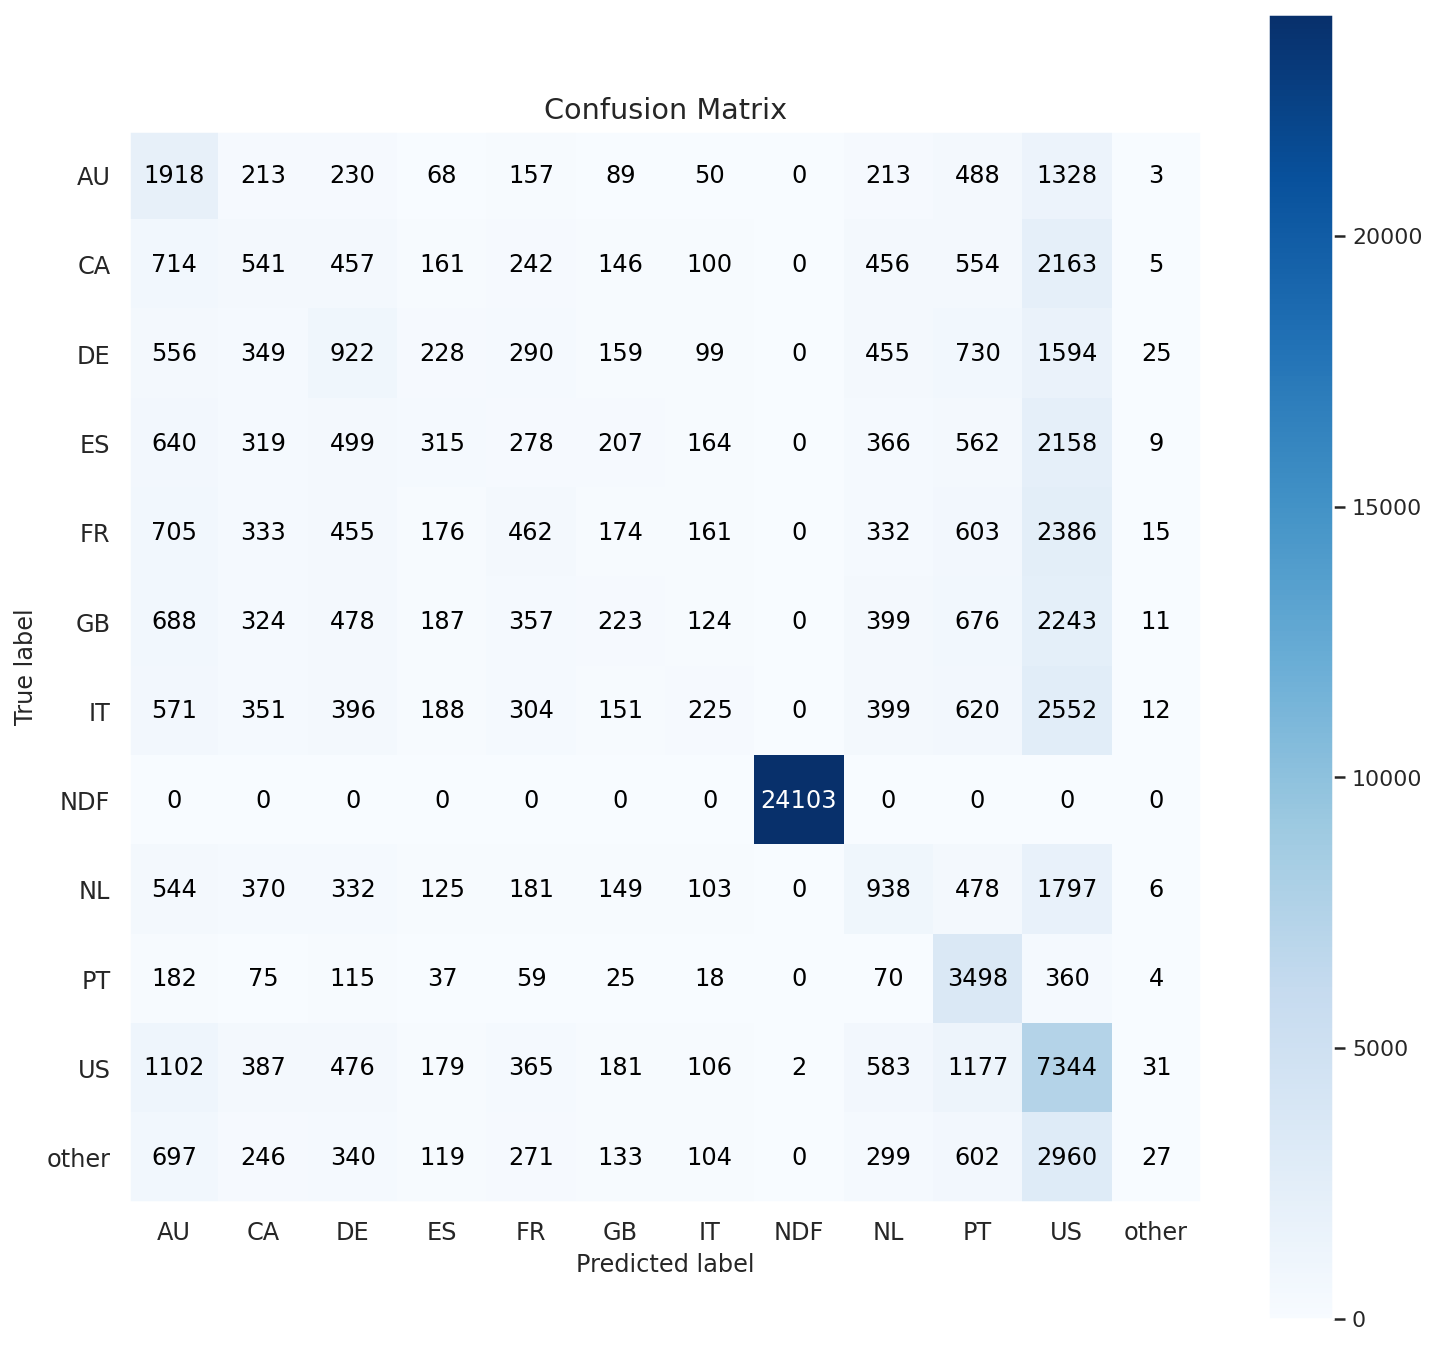

In [102]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 9.1.3 NN Performance - Cross Validation

In [103]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [104]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 4 ), np.round( np.std( balanced_acc_list ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.3657 +/- 0.0064
Avg Kappa: 0.4249 +/- 0.0041
